In [1]:
using POMDPs
using StaticArrays
using LinearAlgebra
using Random
using POMDPModelTools
using Plots

In [2]:
# State of a Drone.
struct DroneState <: FieldVector{4, Float64}
    x::Float64 # x location in meters
    y::Float64 # y location in meters
    theta::Float64 # orientation in radian
    status::Int64 # indicator whether robot has reached goal state or crashed
end

# state-space definitions
struct ContinuousDroneStateSpace end
Base.eltype(sspace::Type{ContinuousDroneStateSpace}) = DroneState


In [3]:
# Struct for a Drone action
struct DroneAct <: FieldVector{2, Float64}
    v::Float64     # meters per second
    omega::Float64 # theta dot (rad/s)
end

# action spaces
struct DroneActions end


In [4]:
# Obstacle and Target area Struct
struct Circle
    x::Float64 # x location in meters
    y::Float64 # y location in meters
    r::Float64 # radius in meters
end

In [5]:

struct Env
    goal::Circle
    obstacles::Vector{Circle}
end

In [6]:
# generate random obstacles
function generate_obstacles(size::SVector{2, SVector{2, Float64}}, num_obstacles::Int64, goal::Circle)
    obstacles = Vector{Circle}()
    min_radius= 2.5
    max_radius = 7.5
    for _ in 1:num_obstacles
        obstacle_x, obstacle_y = rand(size[1][1]:size[1][2]), rand(size[2][1]:size[2][2])
        obstacle_r = rand(min_radius:max_radius)

        ## if target and obstacle regions overlap, generate new obstacle
        while norm([goal.x, goal.y].- [obstacle_x, obstacle_y]) < goal.r + obstacle_r
            obstacle_x, obstacle_y = rand(size[1][1]:size[1][2]), rand(size[2][1]:size[2][2])
            obstacle_r = rand(min_radius:max_radius)
        end
        obstacle = Circle(obstacle_x, obstacle_y, obstacle_r)
        push!(obstacles, obstacle)
    end
    return obstacles
end;

In [7]:
# Define the Drone MDP.
mutable struct DroneMDP <: MDP{DroneState, DroneAct}
    v_max::Float64 # maximum velocity of Drone [m/s]
    om_max::Float64 # maximum turn-rate of Drone [rad/s]
    dt::Float64 # simulation time-step [s]
    pen::Float64 # penalty for crash or out of bounds
    time_pen::Float64 # penalty per time-step
    goal_reward::Float64 # reward for reaching goal
    discount::Float64
    size::SVector{2, SVector{2, Float64}}
    sspace::ContinuousDroneStateSpace
    num_obstacles::Int64
    goal::Circle
    env::Env
    aspace::DroneActions
end

function DroneMDP(;
            v_max=2.0, 
            om_max=1.0, 
            dt=0.5, 
            pen=-1000.0, 
            time_pen=-1.0, 
            goal_reward=100.0,
            discount=0.95,
            size=SVector(SVector(0.0, 50.0), SVector(0.0, 50.0)),
            sspace=ContinuousDroneStateSpace(),
            num_obstacles=10, 
            aspace=DroneActions())
            Random.seed!(1)
            goal= Circle(rand(size[1][1]:size[1][2]), rand(size[2][1]:size[2][2]), 5.0)
            env = Env(goal,generate_obstacles(size,num_obstacles,goal))
        return DroneMDP(v_max,om_max,dt,pen,time_pen,goal_reward,discount,
                        size,sspace,num_obstacles,goal,env,aspace)
end;

In [8]:
const DroneModel = Union{DroneMDP};

In [9]:
# access the mdp of a DroneModel
mdp(e::DroneMDP) = e;

In [10]:
# access the Enviroment of a DroneModel
env(m::DroneMDP) = m.env;

In [11]:
# access the state space of a DroneModel
sspace(m::DroneMDP) = m.sspace;

In [12]:
POMDPs.actions(m::DroneModel) = mdp(m).aspace
n_actions(m::DroneModel) = length(mdp(m).aspace);

In [13]:
# transition Drone state given curent state and action
POMDPs.transition(m::DroneMDP, s::DroneState, a::DroneAct) = Deterministic(get_next_state(m, s, a))

In [14]:
# terminal condition handling
function terminal(m::DroneMDP,x,y)
    distance_to_target = norm([x, y].- [m.env.goal.x, m.env.goal.y])
    if distance_to_target <= m.env.goal.r
        return 1
    end

    for i in 1:length(m.env.obstacles)
        distance_to_obstacle = norm([x, y].- [m.env.obstacles[i].x, m.env.obstacles[i].y])
        if distance_to_obstacle <= m.env.obstacles[i].r
            return -1
        end
    end

    # check for out of bounds
    if x >= m.size[1][2] || x <= m.size[1][1] || y >= m.size[2][2] || y <= m.size[2][1]
        return -1
    end

    return 0
end;

In [15]:
function get_next_state(m::DroneMDP, s::DroneState, a::DroneAct)
    v, om = a
    v = clamp(v, -m.v_max, m.v_max)
    om = clamp(om, -m.om_max, m.om_max)

    x, y, th, status = s
    dt = m.dt

    # dynamics assume drone rotates and then translates
    next_th = mod( th + om*dt,2*pi)

    # make sure we arent going through a wall
    p0 = SVector(x, y)
    heading = SVector(cos(next_th), sin(next_th))
    des_step = v*dt
    pos = p0 + des_step*heading

    # Determine whether reached goal, obstacle or out of bounds
    next_status =  terminal(m,pos[1],pos[2])
        
    

    # define next state
    return DroneState(pos[1], pos[2], next_th, next_status)
end;

In [16]:
# enumerate all possible states in a DiscreteDroneStateSpace
POMDPs.states(m::DroneModel) = sspace(m)


In [17]:
# defines reward function R(s,a,s')
function POMDPs.reward(m::DroneModel,s::DroneState, a::DroneAct,sp::DroneState)
    
    # penalty for each timestep elapsed
    cum_reward = mdp(m).time_pen

    # terminal rewards
    cum_reward += mdp(m).goal_reward*(sp.status == 1)
    cum_reward += mdp(m).pen*(sp.status == -1)

    return cum_reward  
end

In [18]:
# determine if a terminal state has been reached
POMDPs.isterminal(m::DroneModel, s::DroneState) = abs(s.status) > 0.0

In [19]:
# define discount factor
POMDPs.discount(m::DroneModel) = mdp(m).discount

In [20]:
# struct to define an initial distribution over Drone states
struct DroneInitialDistribution{M<:DroneModel}
    m::M
end

# definition of initialstate for Drone environment
POMDPs.initialstate(m::DroneModel) = DroneInitialDistribution(m)

In [21]:
#Generate points for the circle
function plot_circle(x, y, r, fill_color=:none)
    theta = LinRange(0, 2π, 100)  # Angle range from 0 to 2π
    circle_x = x .+ r * cos.(theta)
    circle_y = y .+ r * sin.(theta)
    return plot!(circle_x, circle_y, aspect_ratio=1, legend=false, fillalpha=0.7, fillopacity=0.7, fill=true, fillcolor=fill_color)
end

##Render MDP 
function render(m::DroneMDP,s=DroneState(0.0, 0.0, 0.0, 0.0); show=true, t=nothing)
    p = plot(size=(700, 700), xlim=(m.size[1][1]-2, m.size[1][2]+2), ylim=(m.size[2][1]-2, m.size[2][2]+2), legend=false)
    xticks!(0:5:m.size[1][2]+1)
    yticks!(0:5:m.size[2][2]+1)
    for (i, obs) in enumerate(m.env.obstacles)
        plot_circle(obs.x, obs.y, obs.r,:red)
    end
    plot_circle(m.env.goal.x, m.env.goal.y, m.env.goal.r,:green)
    quiver!([s[1]], [s[2]], quiver=[(1*cos(s[3]), 1*sin(s[3]))], color=:blue, arrow=true, linewidth=2)
    
    plot!([m.size[1][1]+0.5, m.size[2][1]+0.5], [m.size[1][1]+0.5, m.size[2][2]+0.5], color=:black, linewidth=2)  # (0.5,0.5) to (0.5,10.5)
    plot!([m.size[1][1]+0.5, m.size[2][2]+0.5], [m.size[1][1]+0.5, m.size[2][1]+0.5], color=:black, linewidth=2)  # (0.5,0.5) to (10.5,0.5)
    plot!([m.size[1][1]+0.5, m.size[2][2]+0.5], [m.size[1][2]+0.5, m.size[2][2]+0.5], color=:black, linewidth=2)  # (0.5,10.5) to (10.5,10.5)
    plot!([m.size[1][2]+0.5, m.size[2][2]+0.5], [m.size[1][2]+0.5, m.size[2][1]+0.5], color=:black, linewidth=2)  # (10.5,10.5) to (10.5,0.5)
    if !isnothing(t)
        annotate!(m.size[1][2]/2, m.size[2][2]-2, text("t=$t", :center, 12))
    end

    if show
        display(p)
    end
end;

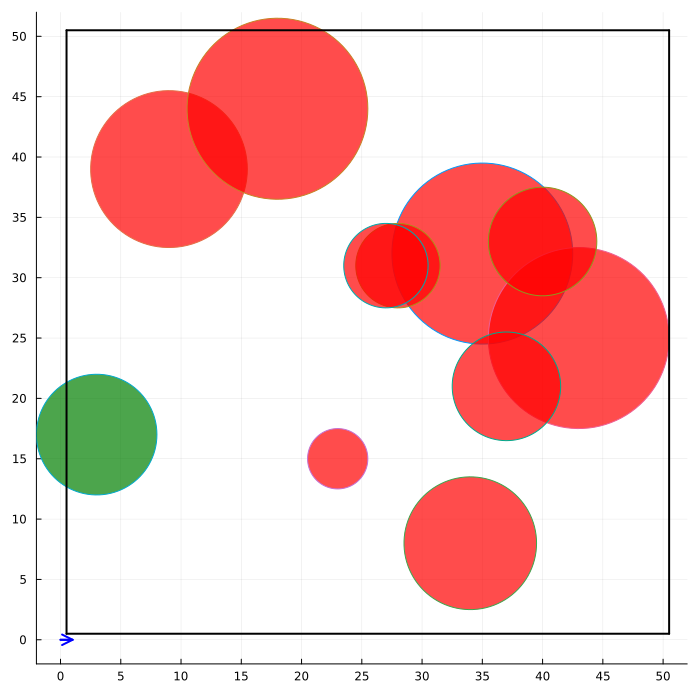

In [22]:
    m = DroneMDP()
render(m)